# **Research Notebook 05: Model Evaluation & Comparison**

**Objective:** Load both trained models (Baseline & DistilBERT), run inference on the held-out test set, and generate comparative visualizations (Confusion Matrix, ROC)

In [1]:
# Install Dependencies

!pip install -q transformers datasets accelerate

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

In [3]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define File Paths

base_path = '/content/drive/MyDrive/Research/'
test_path = f'{base_path}datasets/test_dataset_clean.csv'
baseline_path = f'{base_path}models/baseline_model_clean.pkl'
bert_path = f'{base_path}models/distilbert_finetuned_cased'
evaluation_path = f'{base_path}evaluation/'

In [5]:
# Load Test Data

print("Loading test dataset...")
df_test = pd.read_csv(test_path)

# Map labels to numbers for metrics
label_map = {'fake': 0, 'real': 1}
df_test['label_id'] = df_test['label'].map(label_map)

print(f"\nTest Set Size: {len(df_test)}")

Loading test dataset...

Test Set Size: 2256


In [6]:
# ---------------------------------------------------------
# PART A: BASELINE MODEL EVALUATION
# ---------------------------------------------------------

print("--- PART A: Evaluating Baseline Model (TF-IDF) ---")
print("\nLoading Baseline Model...")

baseline_model = joblib.load(baseline_path)

# Predict (TF-IDF requires 'cleaned_text_tfidf')
print("Running Baseline Inference...")
X_test_tfidf = df_test['cleaned_text_tfidf'].fillna("") # Handle potential NaNs safely

# Get predictions and probabilities
baseline_preds = baseline_model.predict(X_test_tfidf)
baseline_probs = baseline_model.predict_proba(X_test_tfidf)[:, 1] # Prob of 'real'

# Map string predictions back to numbers for comparison
# The pipeline outputs 'fake'/'real' strings
baseline_preds_num = [label_map[p] for p in baseline_preds]

print("\nBaseline Evaluation Complete.")

--- PART A: Evaluating Baseline Model (TF-IDF) ---

Loading Baseline Model...
Running Baseline Inference...

Baseline Evaluation Complete.


In [7]:
# ---------------------------------------------------------
# PART B: DISTILBERT EVALUATION
# ---------------------------------------------------------
print("--- PART B: Evaluating Advanced Model (DistilBERT) ---")

if 'device' not in locals():
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nDevice re-initialized: {device}")

print("\nLoading DistilBERT Model & Tokenizer...")

tokenizer = DistilBertTokenizerFast.from_pretrained(bert_path)
model = DistilBertForSequenceClassification.from_pretrained(bert_path)
model.to(device)
model.eval() # Set to evaluation mode

# Prepare Data for BERT (Use 'preprocessed_text_bert')
print("Tokenizing Test Data for BERT...")
bert_data = df_test[['preprocessed_text_bert', 'label_id']].rename(columns={'label_id': 'labels'})
hf_dataset = Dataset.from_pandas(bert_data)

def tokenize_function(batch):
    return tokenizer(batch['preprocessed_text_bert'], truncation=True, max_length=512)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)
# Remove raw text columns to avoid errors in DataLoader
tokenized_datasets = tokenized_datasets.remove_columns(['preprocessed_text_bert'])
tokenized_datasets.set_format("torch")

# Create DataLoader for batch inference
data_collator = DataCollatorWithPadding(tokenizer)
dataloader = DataLoader(tokenized_datasets, batch_size=32, shuffle=False, collate_fn=data_collator)

print("Running DistilBERT Inference...")
bert_preds_num = []
bert_probs = []

with torch.no_grad():
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        # Apply Softmax to get probabilities
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)

        bert_preds_num.extend(preds.cpu().numpy())
        bert_probs.extend(probs[:, 1].cpu().numpy()) # Prob of class 1 ('real')

print("\nDistilBERT Evaluation Complete.")

--- PART B: Evaluating Advanced Model (DistilBERT) ---

Device re-initialized: cuda

Loading DistilBERT Model & Tokenizer...
Tokenizing Test Data for BERT...


Map:   0%|          | 0/2256 [00:00<?, ? examples/s]

Running DistilBERT Inference...

DistilBERT Evaluation Complete.


--- PART C: Generating Visualizations ---



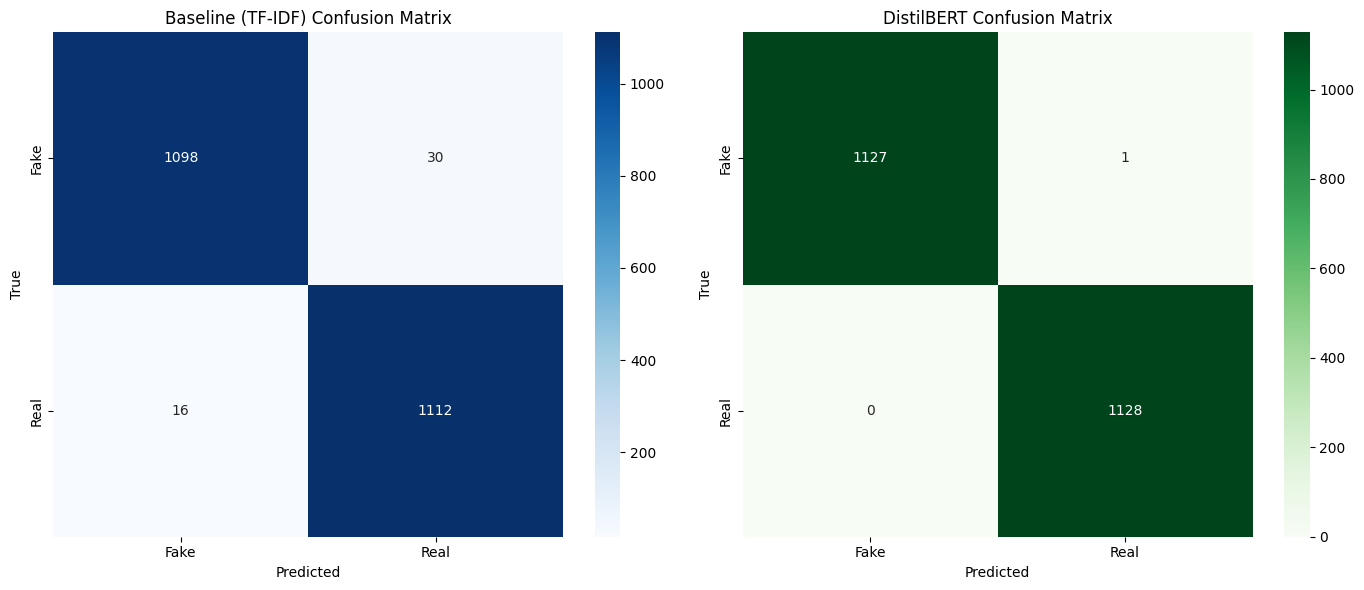

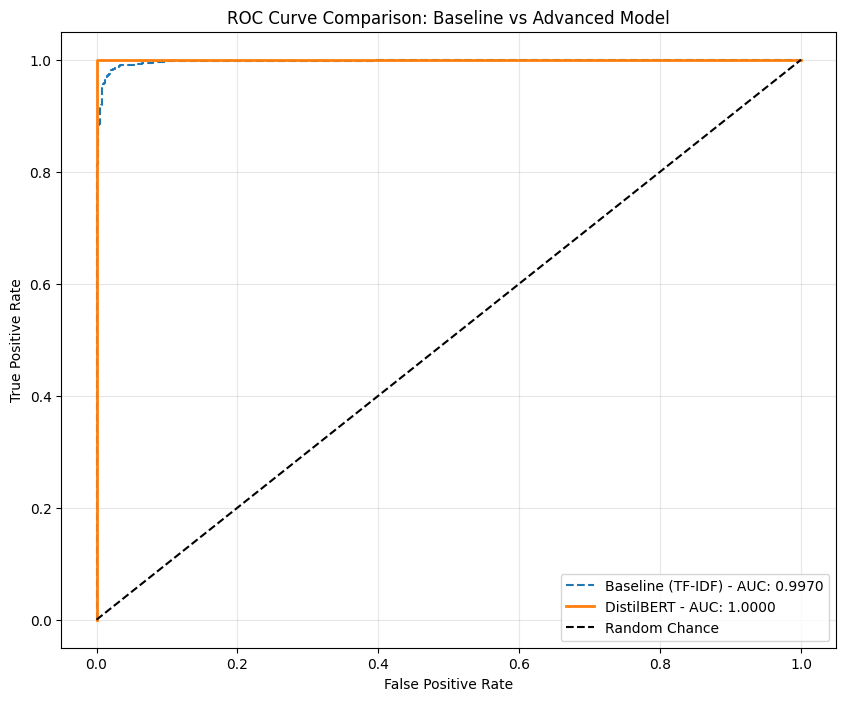


=== FINAL HEAD-TO-HEAD RESULTS ===


,Model,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),ROC AUC
0,Baseline (TF-IDF),0.9796,0.9797,0.9796,0.9796,0.997
1,DistilBERT,0.9996,0.9996,0.9996,0.9996,1.000


In [8]:
# ---------------------------------------------------------
# PART C: VISUALIZATION & COMPARISON
# ---------------------------------------------------------
print("--- PART C: Generating Visualizations ---\n")

y_true = df_test['label_id'].values

# 1. Confusion Matrix Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline CM
cm_base = confusion_matrix(y_true, baseline_preds_num, labels=[0, 1])
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
axes[0].set_title('Baseline (TF-IDF) Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# DistilBERT CM
cm_bert = confusion_matrix(y_true, bert_preds_num, labels=[0, 1])
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
axes[1].set_title('DistilBERT Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()

save_path_cm = f"{evaluation_path}confusion_matrix_comparison.png"
plt.savefig(save_path_cm, dpi=300)

plt.show()

print('\n')

# 2. ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Baseline ROC
fpr_base, tpr_base, _ = roc_curve(y_true, baseline_probs)
auc_base = roc_auc_score(y_true, baseline_probs)
plt.plot(fpr_base, tpr_base, label=f'Baseline (TF-IDF) - AUC: {auc_base:.4f}', linestyle='--')

# DistilBERT ROC
fpr_bert, tpr_bert, _ = roc_curve(y_true, bert_probs)
auc_bert = roc_auc_score(y_true, bert_probs)
plt.plot(fpr_bert, tpr_bert, label=f'DistilBERT - AUC: {auc_bert:.4f}', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Baseline vs Advanced Model')
plt.legend()
plt.grid(True, alpha=0.3)

save_path_roc = f"{evaluation_path}roc_curve_comparison.png"
plt.savefig(save_path_roc, dpi=300)

plt.show()

# 3. Final Metrics Table
print("\n=== FINAL HEAD-TO-HEAD RESULTS ===")
results = []

results.append({
    'Model': 'Baseline (TF-IDF)',
    'Accuracy': accuracy_score(y_true, baseline_preds_num),
    'Precision (Macro)': precision_score(y_true, baseline_preds_num, average='macro'),
    'Recall (Macro)': recall_score(y_true, baseline_preds_num, average='macro'),
    'F1 (Macro)': f1_score(y_true, baseline_preds_num, average='macro'),
    'ROC AUC': auc_base
})

results.append({
    'Model': 'DistilBERT',
    'Accuracy': accuracy_score(y_true, bert_preds_num),
    'Precision (Macro)': precision_score(y_true, bert_preds_num, average='macro'),
    'Recall (Macro)': recall_score(y_true, bert_preds_num, average='macro'),
    'F1 (Macro)': f1_score(y_true, bert_preds_num, average='macro'),
    'ROC AUC': auc_bert
})

results_df = pd.DataFrame(results)

# Make the metrics table reproducible
results_df = results_df.round(4)
results_df

In [9]:
# Save evaluation metrics as a table

metrics_comparison_save_path = f'{evaluation_path}metrics_comparison.csv'
results_df.to_csv(metrics_comparison_save_path, index=False)

print(f"Metrics Comparison saved to: {metrics_comparison_save_path}")

Metrics Comparison saved to: /content/drive/MyDrive/Research/evaluation/metrics_comparison.csv


In [10]:
# Add classification reports

print("--- Detailed Classification Reports ---")
print("\nBaseline Classification Report:")
print(classification_report(y_true, baseline_preds_num, target_names=['Fake', 'Real']))
print("\nDistilBERT Classification Report:")
print(classification_report(y_true, bert_preds_num, target_names=['Fake', 'Real']))

print("\nEvaluation Script Complete.")

--- Detailed Classification Reports ---

Baseline Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      1128
        Real       0.97      0.99      0.98      1128

    accuracy                           0.98      2256
   macro avg       0.98      0.98      0.98      2256
weighted avg       0.98      0.98      0.98      2256


DistilBERT Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      1128
        Real       1.00      1.00      1.00      1128

    accuracy                           1.00      2256
   macro avg       1.00      1.00      1.00      2256
weighted avg       1.00      1.00      1.00      2256


Evaluation Script Complete.
